# GFN1-xTB: Bandstructure of Silicon

This example shows how to use PLAMS and ParAMS to refit the bandstructure of silicon from GFN1-xTB based on BAND reference calculation. We also include in the fitting, the repulsive part of the potential to improve the description of the silicon volume scan. We start with some imports.

In [1]:
import scm.plams as plams
import scm.params as params
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import numpy as np

In [2]:
plams.init()

PLAMS working folder: /Users/nonofrio/Documents/amshome_fix2024/scripting/scm/params/doc/source/examples/xtb_si/plams_workdir


## Some settings and functions

We first define some settings to run BAND, xTB, and some tasks such as Single Point and equation of state (EOS).

In [3]:
s_band = plams.Settings()
s_band.input.BAND.Basis.Type = "TZP"
s_band.input.BAND.XC.GGA = "PBE"
s_band.input.BAND.XC.DISPERSION = "Grimme3"
s_band.input.BAND.BandStructure.Enabled = "Yes"

In [4]:
s_xTB = plams.Settings()
s_xTB.input.dftb.model = 'GFN1-xTB'

In [5]:
s_sp = plams.Settings()
s_sp.input.ams.Task = "SinglePoint"

In [6]:
s_eos = plams.Settings()
s_eos.input.ams.Task = "pesscan"
s_eos.input.ams.PESScan.ScanCoordinate.NPoints = 5
s_eos.input.ams.PESScan.ScanCoordinate.CellVolumeScalingRange = "0.80 1.20"
s_eos.input.ams.PESScan.CalcPropertiesAtPESPoints = "Yes"
s_eos.input.ams.Properties.StressTensor = "Yes"
s_eos.input.ams.Properties.Gradients = "Yes"

Some functions to setup the jobs, extract the EOS, plot the EOS and bandstructure.

In [7]:
def get_job(settings, name, mol):
    job = plams.AMSJob(
        settings=settings,
        molecule=mol,
        name=name
    )
    return job

In [8]:
def get_eos(job):
    to_A = plams.Units.convert(1, 'bohr', 'angstrom')
    to_eV = plams.Units.convert(1, 'au', 'eV')
    vols = np.array(job.results.readrkf('PESScan', 'PESCoords')[0::7])*to_A*to_A*to_A
    energies = np.array(job.results.readrkf('PESScan', 'PES'))*to_eV
    return vols, energies

In [9]:
def plot_eos(x_list,y_list,name_list):
    plt.figure()
    clist = ['b','r','g']
    for i in range(len(x_list)):
        plt.plot(x_list[i],y_list[i]-min(y_list[i]),label=name_list[i],color=clist[i])
    plt.xlabel("Volume in A^3")
    plt.ylabel("Energy in eV")
    plt.legend()
    plt.savefig(f"eos{'_'.join(name_list)}.pdf")

In [10]:
def plot_bands(job,name):
    
    x, y_spin_up, y_spin_down, labels, fermi_energy = job.results.get_band_structure(unit='eV')
    plams.plot_band_structure(x, y_spin_up, None, labels, fermi_energy, zero='fermi')
    plt.ylim(-10, 10)
    plt.ylabel('$E - E_{Fermi}$ (eV)')
    plt.xlabel('Path')
    plt.title(name)
    plt.savefig(f"bands_{name}.pdf") 

In [11]:
def get_bandgap(job, name):
    toeV = plams.Units.convert(1.0, "hartree", "eV")
    topvb = job.results.readrkf("BandStructure", "TopValenceBand", file="engine") * toeV
    bottomcb = job.results.readrkf("BandStructure", "BottomConductionBand", file="engine") * toeV
    gap = bottomcb - topvb
#    print(f"Results ({name}):")
#    print(f"Top of valence band:       {topvb:.2f} eV")
#    print(f"Bottom of conduction band: {bottomcb:.2f} eV")
    print(f"{name} bandgap:                  {gap:.2f} eV")

## Si unit cell

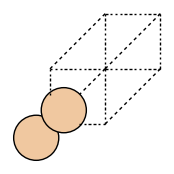

In [12]:
Si_unit = plams.AMSJob.from_input(
    """
    System
        Atoms
            Si -0.67875 -0.67875 -0.67875 
            Si 0.67875 0.67875 0.67875 
        End
        Lattice
            0.0 2.715 2.715
            2.715 0.0 2.715
            2.715 2.715 0.0
        End
    End
"""
).molecule[""]
plams.plot_molecule(Si_unit)

## EOS of Silicon

Let's perform an EOS of Silicon with BAND and xTB and compare the results.

In [13]:
band_eos_job = get_job(s_band + s_eos, "Si_volumescan_BAND", Si_unit)
band_eos_job.run()

[10.07|10:18:02] JOB Si_volumescan_BAND STARTED
[10.07|10:18:02] JOB Si_volumescan_BAND RUNNING
[10.07|10:26:27] JOB Si_volumescan_BAND FINISHED
[10.07|10:26:27] JOB Si_volumescan_BAND SUCCESSFUL


In [14]:
xTB_eos_job = get_job(s_xTB + s_eos, "Si_volumescan_xTB", Si_unit)
xTB_eos_job.run()

[10.07|10:34:31] JOB Si_volumescan_xTB STARTED
[10.07|10:34:31] JOB Si_volumescan_xTB RUNNING
[10.07|10:35:24] JOB Si_volumescan_xTB FINISHED
[10.07|10:35:24] JOB Si_volumescan_xTB SUCCESSFUL


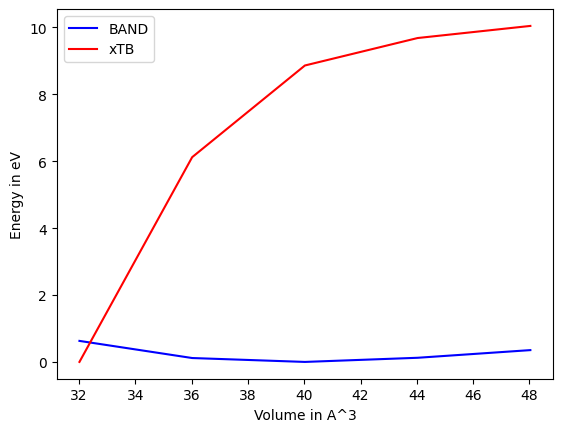

In [15]:
x_band,y_band = get_eos(band_eos_job)
x_xTB,y_xTB = get_eos(xTB_eos_job)
plot_eos([x_band,x_xTB],[y_band,y_xTB],["BAND","xTB"])

## Bandstructure of Silicon

Similarly we now perform the bandstructure calculation of Silicon with BAND and xTB and compare the results.

In [16]:
band_bandstructure_job = get_job(s_band + s_sp, "Si_bandstructure_BAND", Si_unit)
band_bandstructure_job.run()

[10.07|10:35:48] JOB Si_bandstructure_BAND STARTED
[10.07|10:35:48] JOB Si_bandstructure_BAND RUNNING
[10.07|10:36:33] JOB Si_bandstructure_BAND FINISHED
[10.07|10:36:33] JOB Si_bandstructure_BAND SUCCESSFUL


In [17]:
xTB_bandstructure_job = get_job(s_xTB + s_sp, "Si_bandstructure_xTB", Si_unit)
xTB_bandstructure_job.run()

[10.07|10:38:49] JOB Si_bandstructure_xTB STARTED
[10.07|10:38:49] JOB Si_bandstructure_xTB RUNNING
[10.07|10:38:53] JOB Si_bandstructure_xTB FINISHED
[10.07|10:38:53] JOB Si_bandstructure_xTB SUCCESSFUL


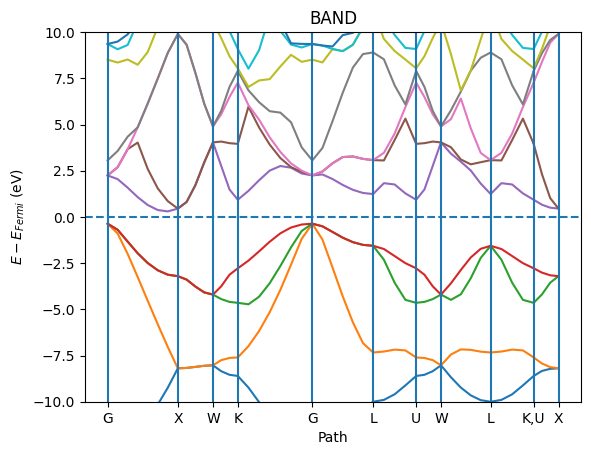

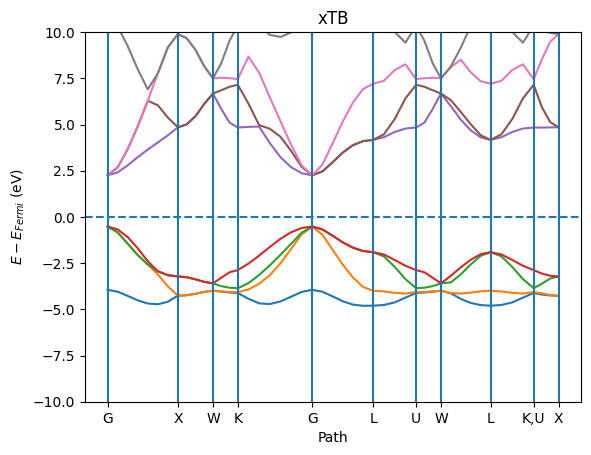

In [18]:
plot_bands(band_bandstructure_job,"BAND")
plot_bands(xTB_bandstructure_job,"xTB")

In [19]:
get_bandgap(band_bandstructure_job,"BAND")
get_bandgap(xTB_bandstructure_job,"xTB")

BAND bandgap:                  0.82 eV
xTB bandgap:                  2.77 eV


## ParAMS optimization

We now setup ParAMS to optimize xTB parameters to improve the bandstructure of Silicon. Note that we also include the EOS of Silicon to maintain and improve the proper geometric description of the crystal during the optimization.

In [20]:
results_importer_settings = plams.Settings()
results_importer_settings.units.energy = 'eV'
results_importer_settings.units.forces = 'eV/angstrom'
ri = params.ResultsImporter(settings=results_importer_settings)

Here we import 10 bands of the bandstructure, as well as the bandgap.

In [21]:
bands_list = list(range(10))
ri.add_singlejob(band_bandstructure_job.results.rkfpath(),properties={'bandstructure(bands='+str(bands_list)+',only_high_symmetry_points=True)': {'unit': 'eV'}})
ri.add_singlejob(band_bandstructure_job.results.rkfpath(),properties={'bandgap':{'weight': 10.0}})

["bandgap('Si_bandstructure_BAND')"]

We import the EOS.

In [22]:
ri.add_pesscan_singlepoints(band_eos_job.results.rkfpath(),
    properties={'relative_energies': {'relative_to': 'min','unit': 'eV', 'weight': 2.0},
               'forces': {'unit': 'eV/angstrom'},
               'stresstensor_diagonal_3d': {'unit': 'GPa'},
               })

["energy('Si_volumescan_BAND_frame001')-energy('Si_volumescan_BAND_frame003')",
 "energy('Si_volumescan_BAND_frame002')-energy('Si_volumescan_BAND_frame003')",
 "energy('Si_volumescan_BAND_frame004')-energy('Si_volumescan_BAND_frame003')",
 "energy('Si_volumescan_BAND_frame005')-energy('Si_volumescan_BAND_frame003')",
 "forces('Si_volumescan_BAND_frame001')",
 "forces('Si_volumescan_BAND_frame002')",
 "forces('Si_volumescan_BAND_frame003')",
 "forces('Si_volumescan_BAND_frame004')",
 "forces('Si_volumescan_BAND_frame005')",
 "stresstensor_diagonal_3d('Si_volumescan_BAND_frame001')",
 "stresstensor_diagonal_3d('Si_volumescan_BAND_frame002')",
 "stresstensor_diagonal_3d('Si_volumescan_BAND_frame003')",
 "stresstensor_diagonal_3d('Si_volumescan_BAND_frame004')",
 "stresstensor_diagonal_3d('Si_volumescan_BAND_frame005')"]

In [23]:
params_folder = "params_Si"
ri.store(folder=params_folder, backup=True)

['params_Si/job_collection.yaml',
 'params_Si/results_importer_settings.yaml',
 'params_Si/training_set.yaml']

Below we define the xTB parameters to optimize.

In [24]:
s = plams.Settings()
interface = params.GFN1xTBParameters(settings=s)
interface['Si:Basis.3p.H_l'].is_active = True
interface['Si:Basis.3p.k_l'].is_active = True
interface['Si:Basis.3p.k_poly'].is_active = True
interface['Si:Basis.3p.zeta_l'].is_active = True

interface['Si:Basis.3s.H_l'].is_active = True
interface['Si:Basis.3s.k_l'].is_active = True
interface['Si:Basis.3s.k_poly'].is_active = True
interface['Si:Basis.3s.zeta_l'].is_active = True

interface['Si:alpha'].is_active = True
interface['Si:eta'].is_active = True
interface['Si:Gamma'].is_active = True
interface['Si:Z'].is_active = True

In [25]:
interface.yaml_store(os.path.join(params_folder,'parameter_interface.yaml'))

And finally some settings for ParAMS.

In [26]:
job = params.ParAMSJob.from_yaml(params_folder, use_relative_paths=True)
job.settings.input.Task = "Optimization"
job.add_optimizer("CMAES", {'Sigma0': 0.01, 'PopSize': 4})
job.add_exit_condition("MaxTotalFunctionCalls", 100)
job.parameter_interface = os.path.join(params_folder,'parameter_interface.yaml')
job.training_set = os.path.join(params_folder,'training_set.yaml')
job.job_collection = os.path.join(params_folder,'job_collection.yaml')
job.training_set.UsePipe = "No"

In [27]:
job.run()

[10.07|10:39:40] JOB plamsjob STARTED
[10.07|10:39:40] JOB plamsjob RUNNING
[10.07|10:57:00] JOB plamsjob FINISHED
[10.07|10:57:00] JOB plamsjob SUCCESSFUL


We can extract and plot the loss function.

In [28]:
epoch, training_loss = job.results.get_running_loss(data_set="training_set")

Text(0.5, 0, 'Epoch')

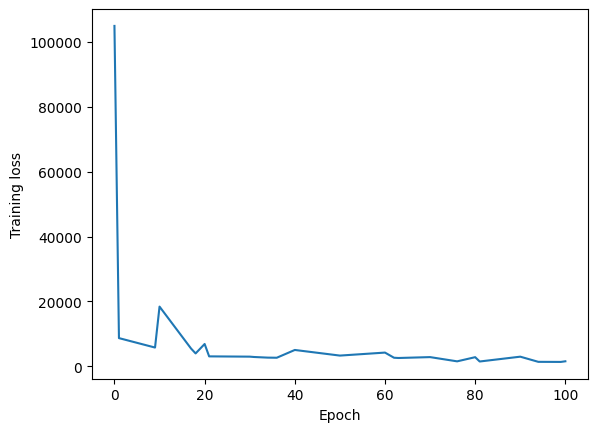

In [29]:
plt.figure()
plt.plot(epoch, training_loss)
plt.ylabel("Training loss")
plt.xlabel('Epoch')
#plt.savefig(f"loss.pdf")

## Validation

Now we can recompute and plot the bandstructure and EOS with the optimized xTB parameters.

In [30]:
s_optxTB = plams.Settings()
s_optxTB.input.dftb.model = "GFN1-xTB"
s_optxTB.input.dftb.ResourcesDir = job.results.get_xtb_files()

In [31]:
optxTB_bandstructure_job = get_job(s_optxTB + s_sp, "Si_bandstructure_optxTB", Si_unit)
optxTB_bandstructure_job.run();

[10.07|11:02:21] JOB Si_bandstructure_optxTB STARTED
[10.07|11:02:21] JOB Si_bandstructure_optxTB RUNNING
[10.07|11:02:24] JOB Si_bandstructure_optxTB FINISHED
[10.07|11:02:24] JOB Si_bandstructure_optxTB SUCCESSFUL


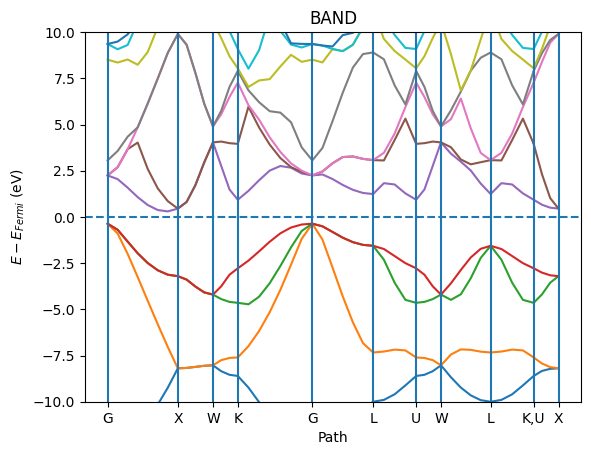

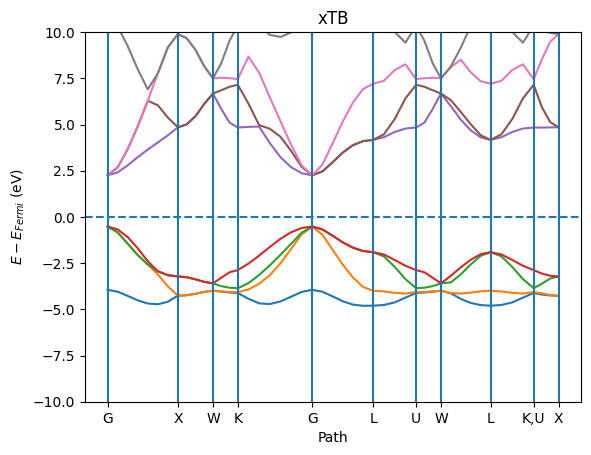

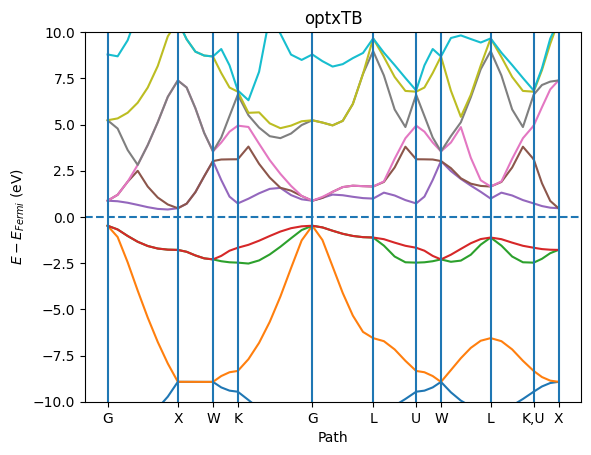

In [32]:
plot_bands(band_bandstructure_job,"BAND")
plot_bands(xTB_bandstructure_job,"xTB")
plot_bands(optxTB_bandstructure_job,"optxTB")

In [33]:
get_bandgap(band_bandstructure_job,"BAND")
get_bandgap(xTB_bandstructure_job,"xTB")
get_bandgap(optxTB_bandstructure_job,"optxTB")

BAND bandgap:                  0.82 eV
xTB bandgap:                  2.77 eV
optxTB bandgap:                  0.95 eV


In [34]:
optxTB_eos_job = get_job(s_optxTB + s_eos, "Si_volumescan_optxTB", Si_unit)
optxTB_eos_job.run();

[10.07|11:02:37] JOB Si_volumescan_optxTB STARTED
[10.07|11:02:37] JOB Si_volumescan_optxTB RUNNING
[10.07|11:03:01] JOB Si_volumescan_optxTB FINISHED
[10.07|11:03:01] JOB Si_volumescan_optxTB SUCCESSFUL


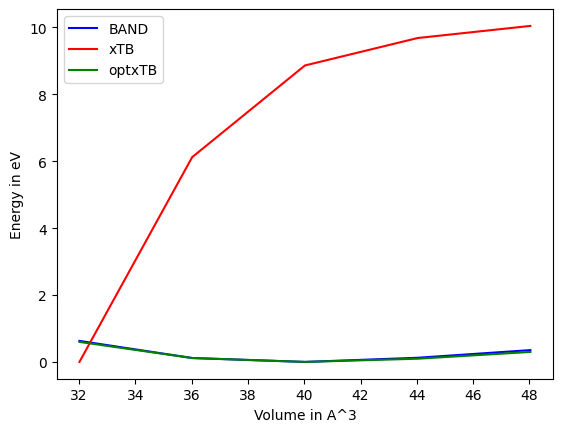

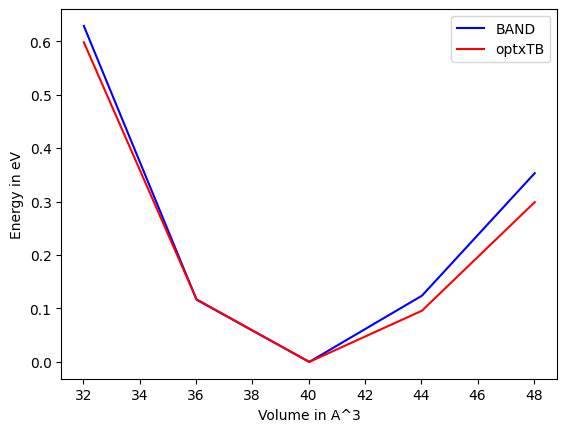

In [35]:
x_optxTB,y_optxTB = get_eos(optxTB_eos_job)
plot_eos([x_band,x_xTB,x_optxTB],[y_band,y_xTB,y_optxTB],["BAND","xTB","optxTB"])
plot_eos([x_band,x_optxTB],[y_band,y_optxTB],["BAND","optxTB"])

What to do next:
- use a more accurate functional in BAND for the electronic structure (HSE06)
- adjust weights to get a better agreement between electronic and atomic structure

In [39]:
plams.finish()

[09.07|18:47:17] PLAMS run finished. Goodbye
